In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 10086
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.bigru_vgg import *
from utils.train import *
from typing import *
from collections import Counter

from utils.load_yelp import *
from utils.dataset import *
from utils.train import *

In [2]:
config = default_config
config["use_img"] = False
config

{'use_cuda': True,
 'task': 'CLS',
 'embedding_dim': 200,
 'embedding': None,
 'freeze_embedding': False,
 'text_hidden_size': 50,
 'text_layers': 1,
 'bias_init': 1.0,
 'use_img': False,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'output_size': 5,
 'dropout': 0.5}

In [3]:
train_set, valid_set, test_set= load_glove_vgg_data(split811data, config)
Counter(train_set.y), Counter(valid_set.y), Counter(test_set.y)

(Counter({1: 7102, 0: 7111, 2: 7076, 4: 7090, 3: 7066}),
 Counter({1: 887, 3: 894, 2: 908, 0: 879, 4: 862}),
 Counter({2: 877, 3: 901, 4: 909, 0: 871, 1: 872}))

In [4]:
batch_size = 128
workers = 4
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, collate_fn, train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
model, get_parameter_number(model), loss 

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


(Model(
   (word_embedding): Embedding(42834, 200)
   (gru): DynamicRNN(
     (RNN): GRU(200, 50, batch_first=True, dropout=0.5, bidirectional=True)
   )
   (output_layer): OutputLayer(
     (fc): Linear(in_features=100, out_features=5, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
   )
 ),
 {'Total': 8642905, 'Trainable': 8642905},
 CrossEntropyLoss())

In [5]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.18803611738148984, 0.1498469094409309),
 Counter({1: 2256, 0: 1041, 2: 866, 3: 208, 4: 59}))

In [6]:
%%time
_interval = 5
lr = 1e-3
epoches = 20
stoping_step = 5
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 277it [00:22, 12.06it/s]


No 1 epoch: train_loss:1.4700491571547467 train_acc:0.3147129355339258 valid_loss:1.1752684868216245 valid_acc:0.4934537246049661


No 2 epoch: 277it [00:23, 11.89it/s]


No 2 epoch: train_loss:1.2608940623142535 train_acc:0.415065594583157 valid_loss:1.0545488057771601 valid_acc:0.5760722347629796


No 3 epoch: 277it [00:23, 12.02it/s]


No 3 epoch: train_loss:1.1756094041706762 train_acc:0.452814219212865 valid_loss:1.010990043418402 valid_acc:0.5742663656884875


No 4 epoch: 277it [00:23, 12.01it/s]


No 4 epoch: train_loss:1.1041201405102115 train_acc:0.48274791931160954 valid_loss:0.988241460307188 valid_acc:0.5803611738148984


No 5 epoch: 277it [00:23, 11.84it/s]


No 5 epoch: train_loss:1.033130923592501 train_acc:0.5182959514741148 valid_loss:0.9912032216720065 valid_acc:0.5751693002257336


No 6 epoch: 277it [00:22, 12.08it/s]


No 6 epoch: train_loss:0.9606867697027376 train_acc:0.5506277331076316 valid_loss:1.0251796259029724 valid_acc:0.5711060948081265


No 7 epoch: 277it [00:24, 11.49it/s]


No 7 epoch: train_loss:0.8915865191335082 train_acc:0.5762730991677246 valid_loss:1.0779749038795317 valid_acc:0.5681715575620767


No 8 epoch: 277it [00:24, 11.33it/s]


No 8 epoch: train_loss:0.8242839861662772 train_acc:0.6037805050077585 valid_loss:1.1578091414733611 valid_acc:0.5501128668171558


No 9 epoch: 277it [00:23, 11.56it/s]


No 9 epoch: train_loss:0.7646178902011107 train_acc:0.623190859077444 valid_loss:1.245636985856308 valid_acc:0.5489841986455982
CPU times: user 3min 33s, sys: 14.8 s, total: 3min 47s
Wall time: 3min 54s


In [8]:
res

{'max_acc': 0.5803611738148984,
 'max_acc_epoch': 4,
 'max_train_acc': 0.48274791931160954,
 'max_acc_train_loss': 1.1041201405102115,
 'max_acc_valid_loss': 0.988241460307188,
 'last_acc': 0.5489841986455982,
 'last_train_acc': 0.623190859077444,
 'last_epoch': 9,
 'last_train_loss': 0.7646178902011107,
 'last_valid_loss': 1.245636985856308}

In [9]:
eval_model(model, test_loader, loss)

((0.5652370203160271, 0.5713902133742785), 0.9924941888512123)

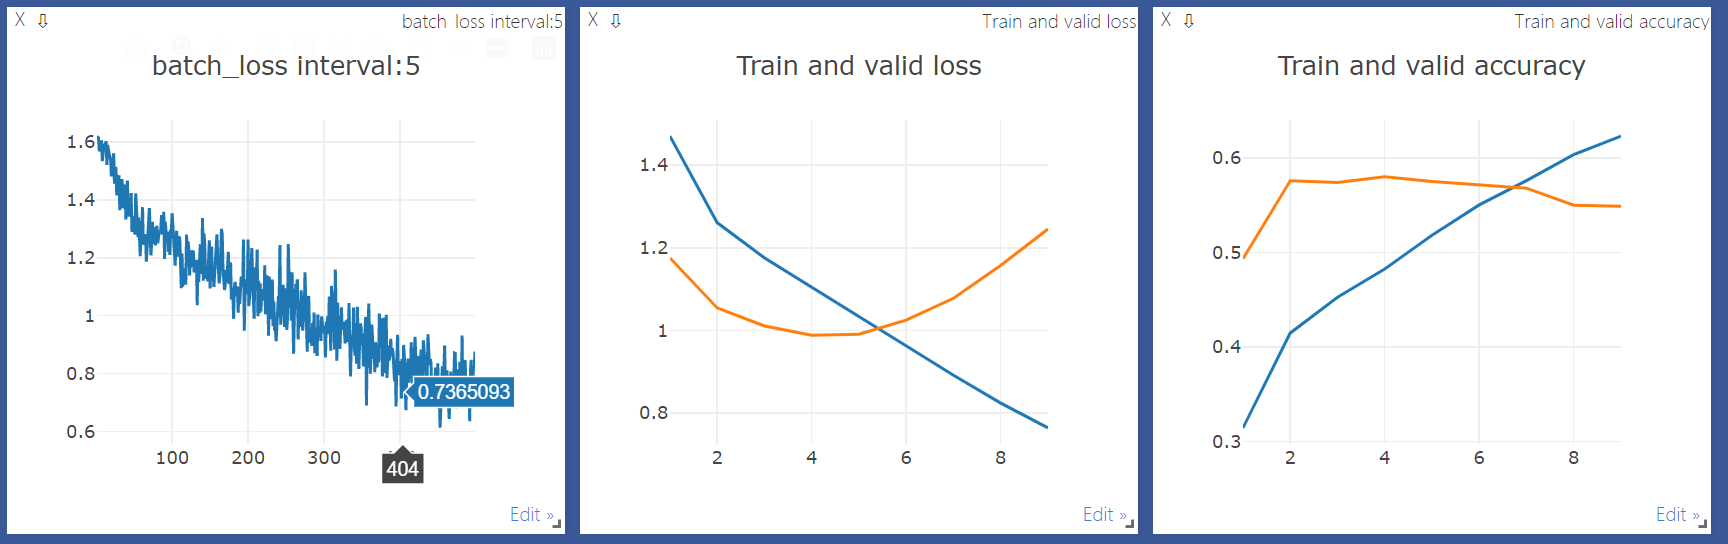

In [10]:
# 加上图片信息
config["use_img"] = True
config

{'use_cuda': True,
 'task': 'CLS',
 'embedding_dim': 200,
 'embedding': Embedding(42834, 200),
 'freeze_embedding': False,
 'text_hidden_size': 50,
 'text_layers': 1,
 'bias_init': 1.0,
 'use_img': True,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'output_size': 5,
 'dropout': 0.5,
 'vocab_size': 42822}

In [11]:
train_set, valid_set, test_set= load_glove_vgg_data(split811data, config)
Counter(train_set.y), Counter(valid_set.y), Counter(test_set.y)

(Counter({1: 7102, 0: 7111, 2: 7076, 4: 7090, 3: 7066}),
 Counter({1: 887, 3: 894, 2: 908, 0: 879, 4: 862}),
 Counter({2: 877, 3: 901, 4: 909, 0: 871, 1: 872}))

In [12]:
batch_size = 128
workers = 4
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, collate_fn, train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
model, get_parameter_number(model), loss 

(Model(
   (word_embedding): Embedding(42834, 200)
   (gru): DynamicRNN(
     (RNN): GRU(200, 50, batch_first=True, dropout=0.5, bidirectional=True)
   )
   (img_encoder): SimpleImageEncoder(
     (linear): Linear(in_features=4096, out_features=100, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
     (relu): ReLU(inplace=True)
     (pooling): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
   )
   (output_layer): OutputLayer(
     (fc): Linear(in_features=200, out_features=5, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
   )
 ),
 {'Total': 9053105, 'Trainable': 9053105},
 CrossEntropyLoss())

In [13]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.21670428893905191, 0.11979868858787623),
 Counter({2: 3760, 0: 503, 4: 124, 3: 10, 1: 33}))

In [14]:
%%time
_interval = 5
lr = 1e-3
epoches = 20
stoping_step = 5
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 277it [00:23, 11.66it/s]


No 1 epoch: train_loss:1.6365606536783173 train_acc:0.3028071660318804 valid_loss:1.2168727535695578 valid_acc:0.49954853273137695


No 2 epoch: 277it [00:23, 11.58it/s]


No 2 epoch: train_loss:1.2673949632376942 train_acc:0.4132881929750317 valid_loss:1.0280763837069475 valid_acc:0.5787810383747178


No 3 epoch: 277it [00:23, 11.67it/s]


No 3 epoch: train_loss:1.1827359915115985 train_acc:0.44928762872055295 valid_loss:0.9875986720046395 valid_acc:0.5896162528216704


No 4 epoch: 277it [00:23, 11.55it/s]


No 4 epoch: train_loss:1.108389601295128 train_acc:0.483001833827056 valid_loss:0.9610188077319557 valid_acc:0.5857787810383747


No 5 epoch: 277it [00:24, 11.50it/s]


No 5 epoch: train_loss:1.03957397037441 train_acc:0.5142333192269714 valid_loss:0.9516966842098107 valid_acc:0.5948081264108352


No 6 epoch: 277it [00:22, 12.20it/s]


No 6 epoch: train_loss:0.9598614910960886 train_acc:0.5479475243334744 valid_loss:0.9962116627876161 valid_acc:0.582392776523702


No 7 epoch: 277it [00:24, 11.38it/s]


No 7 epoch: train_loss:0.8857368992134721 train_acc:0.5821695584708704 valid_loss:1.074947256105479 valid_acc:0.5575620767494357


No 8 epoch: 277it [00:23, 11.90it/s]


No 8 epoch: train_loss:0.8062199000243425 train_acc:0.6122725349132458 valid_loss:1.145740704773242 valid_acc:0.5602708803611738


No 9 epoch: 277it [00:23, 11.86it/s]


No 9 epoch: train_loss:0.7492706154495591 train_acc:0.6290873183805896 valid_loss:1.221139988296457 valid_acc:0.5553047404063205


No 10 epoch: 277it [00:23, 11.62it/s]


No 10 epoch: train_loss:0.6923793155697341 train_acc:0.6504725631259698 valid_loss:1.333180969778625 valid_acc:0.5525959367945824
CPU times: user 3min 58s, sys: 19.1 s, total: 4min 17s
Wall time: 4min 23s


In [15]:
res

{'max_acc': 0.5948081264108352,
 'max_acc_epoch': 5,
 'max_train_acc': 0.5142333192269714,
 'max_acc_train_loss': 1.03957397037441,
 'max_acc_valid_loss': 0.9516966842098107,
 'last_acc': 0.5525959367945824,
 'last_train_acc': 0.6504725631259698,
 'last_epoch': 10,
 'last_train_loss': 0.6923793155697341,
 'last_valid_loss': 1.333180969778625}

In [16]:
eval_model(model, test_loader, loss)

((0.5826185101580136, 0.5841123184983479), 0.9701988455404277)

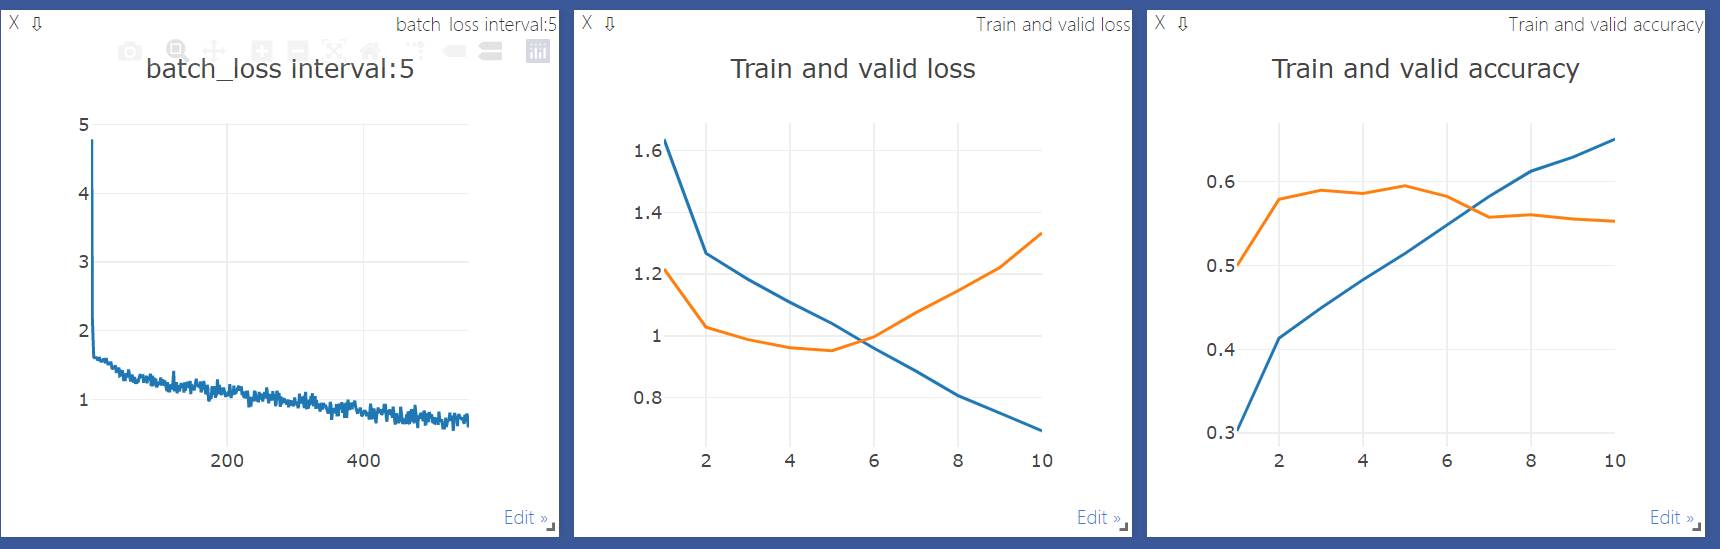

In [17]:
train_set, valid_set, test_set= load_glove_vgg_data(split622data, config)
Counter(train_set.y), Counter(valid_set.y), Counter(test_set.y)

(Counter({4: 5354, 0: 5207, 3: 5362, 1: 5331, 2: 5329}),
 Counter({1: 1796, 2: 1745, 3: 1745, 0: 1831, 4: 1744}),
 Counter({0: 1823, 4: 1763, 3: 1754, 2: 1787, 1: 1734}))

In [18]:
batch_size = 128
workers = 4
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, collate_fn, train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
model, get_parameter_number(model), loss 

(Model(
   (word_embedding): Embedding(41279, 200)
   (gru): DynamicRNN(
     (RNN): GRU(200, 50, batch_first=True, dropout=0.5, bidirectional=True)
   )
   (img_encoder): SimpleImageEncoder(
     (linear): Linear(in_features=4096, out_features=100, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
     (relu): ReLU(inplace=True)
     (pooling): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
   )
   (output_layer): OutputLayer(
     (fc): Linear(in_features=200, out_features=5, bias=True)
     (dropout): Dropout(p=0.5, inplace=True)
   )
 ),
 {'Total': 8742105, 'Trainable': 8742105},
 CrossEntropyLoss())

In [19]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.18485498250761764, 0.13022313719792322),
 Counter({2: 2678, 0: 5077, 4: 1021, 1: 84, 3: 1}))

In [20]:
%%time
_interval = 5
lr = 1e-3
epoches = 20
stoping_step = 5
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 208it [00:18, 11.39it/s]


No 1 epoch: train_loss:1.7409133504171859 train_acc:0.2853327314449084 valid_loss:1.2576708123802587 valid_acc:0.4639431215438438


No 2 epoch: 208it [00:18, 11.47it/s]


No 2 epoch: train_loss:1.3036230200682242 train_acc:0.3977730128277471 valid_loss:1.086597061617328 valid_acc:0.5570477372757026


No 3 epoch: 208it [00:17, 12.12it/s]


No 3 epoch: train_loss:1.218613091456147 train_acc:0.43050069593349133 valid_loss:1.0225702999354136 valid_acc:0.5781514501749239


No 4 epoch: 208it [00:18, 11.55it/s]


No 4 epoch: train_loss:1.1435095186145268 train_acc:0.46849490275740135 valid_loss:1.0120503794674733 valid_acc:0.5710416431554001


No 5 epoch: 208it [00:17, 11.61it/s]


No 5 epoch: train_loss:1.0731812355028014 train_acc:0.4988902682165294 valid_loss:0.9905959973821198 valid_acc:0.5720573298724749


No 6 epoch: 208it [00:18, 11.49it/s]


No 6 epoch: train_loss:1.004036121137371 train_acc:0.5292103976225407 valid_loss:1.0355912288361835 valid_acc:0.5584019862318023


No 7 epoch: 208it [00:18, 11.42it/s]


No 7 epoch: train_loss:0.9227393119826577 train_acc:0.5670541323402174 valid_loss:1.0546185353609203 valid_acc:0.5541135312041531


No 8 epoch: 208it [00:17, 11.65it/s]


No 8 epoch: train_loss:0.8408003523432903 train_acc:0.5987661287288869 valid_loss:1.1292251316476738 valid_acc:0.5439566640334048
CPU times: user 2min 27s, sys: 13.5 s, total: 2min 40s
Wall time: 2min 55s


In [21]:
res

{'max_acc': 0.5781514501749239,
 'max_acc_epoch': 3,
 'max_train_acc': 0.43050069593349133,
 'max_acc_train_loss': 1.218613091456147,
 'max_acc_valid_loss': 1.0225702999354136,
 'last_acc': 0.5439566640334048,
 'last_train_acc': 0.5987661287288869,
 'last_epoch': 8,
 'last_train_loss': 0.8408003523432903,
 'last_valid_loss': 1.1292251316476738}

In [22]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.576910055298499, 0.5746642528590119), 1.0257422598069388)

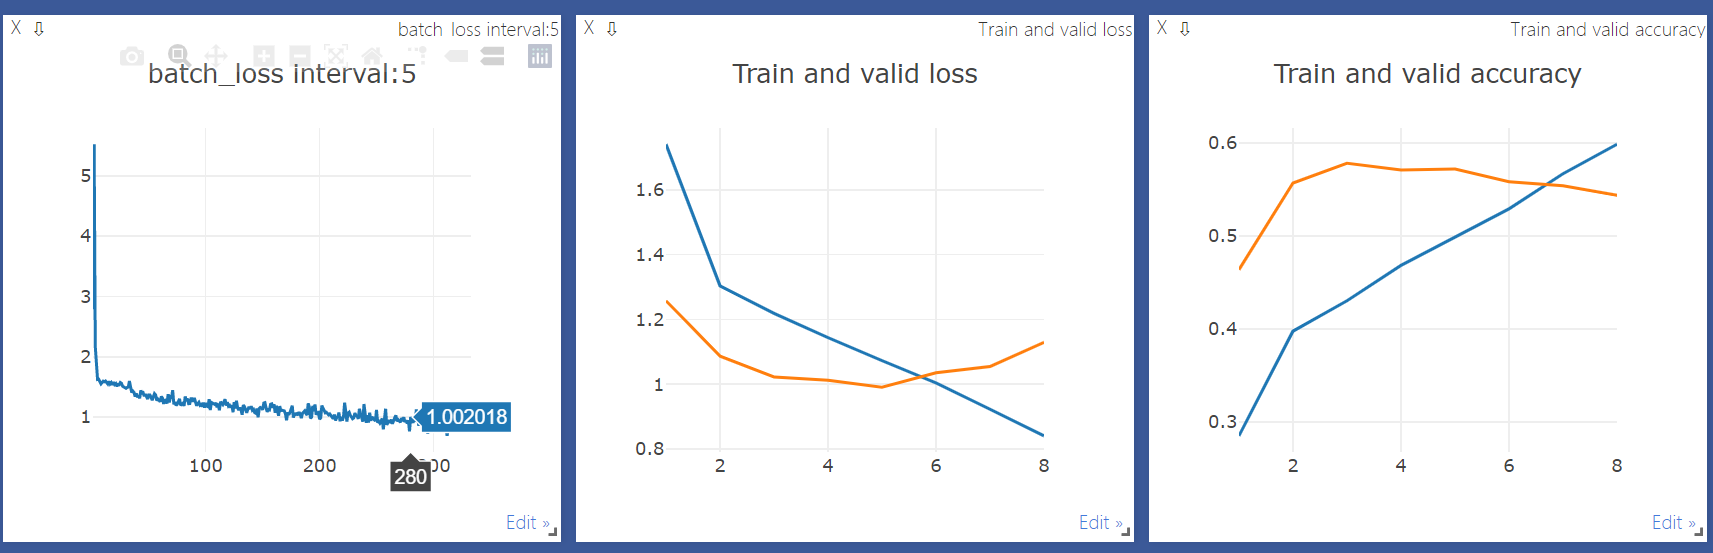